In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pickle, os
import pandas as pd
from tqdm import tqdm 

## Load Important Function

In [2]:
class Data:
    def __init__(self, array_list):
        self.array_list = array_list

    def save(self, filename):
        with open(filename, 'wb') as f:
            pickle.dump(self.array_list, f)

    @classmethod
    def load(cls, filename):
        with open(filename, 'rb') as f:
            array_list = pickle.load(f)
        return cls(array_list)

In [3]:
def omega2cistrans(omega):
    """Converts a sequence of float omega angles (in degrees) to an array of ints: 0 cis and 1 trans."""
    
    shifted_omega = (omega + 90.0) % 360.0 - 90.0 # shift into (-90, 270) range to avoid periodic boundaries
    
    cistrans = np.where(shifted_omega > 90.0, 1, 0).astype(int)
    return cistrans

In [4]:
import numpy as np
from tqdm import tqdm

def calculate_conform_p(trajs, conform_num):
    """
    Calculates the cumulative average population of each conformational state over time,
    excluding NaN values in the trajectory.

    Parameters
    ----------
    trajs : np.ndarray
        A 1D array of shape (timesteps,), where each value is either an integer in 
        [0, conform_num-1] or NaN (for missing data).

    conform_num : int
        The total number of conformational states.

    Returns
    -------
    conform_population : np.ndarray
        Array of shape (conform_num, valid_timesteps) — cumulative average population per conformation.
    """
    trajs = np.asarray(trajs)

    # Only keep valid time steps (non-NaN)
    valid_mask = ~np.isnan(trajs)
    trajs_clean = trajs[valid_mask]
    n_time = trajs_clean.shape[0]

    conform_population = np.zeros((conform_num, n_time), dtype=float)

    for conform_state in range(conform_num):
        match_mask = (trajs_clean == conform_state).astype(float)  # shape: (n_time,)

        cumulative_counts = np.cumsum(match_mask)  # shape: (n_time,)
        time_steps = np.arange(1, n_time + 1)      # shape: (n_time,)

        cumulative_proportions = cumulative_counts / time_steps  # shape: (n_time,)
        conform_population[conform_state] = cumulative_proportions

    #print('Conform population shape:', conform_population.shape)

    return conform_population


## The Trans Population overtime Plot

In [5]:
omega_all_state = []

for i in range(6):
    omega_state = np.array(Data.load(f'omega_data/omegas_state{i}.pkl').array_list)
    omega_all_state.append(omega_state)

omega_all_state = np.array(omega_all_state)
omega_all_state.shape


(6, 600030, 3)

In [6]:
ntraj = len(omega_all_state)
print('np.array(omega_all_state).shape', np.array(omega_all_state).shape)

cistrans = omega2cistrans(omega_all_state)
print('cistrans.shape', cistrans.shape)

cistrans[0, :10, :]

np.array(omega_all_state).shape (6, 600030, 3)
cistrans.shape (6, 600030, 3)


array([[1, 1, 1],
       [1, 1, 1],
       [1, 1, 1],
       [1, 1, 1],
       [1, 0, 1],
       [1, 0, 1],
       [1, 1, 1],
       [1, 1, 1],
       [1, 0, 1],
       [1, 0, 1]])

In [12]:
thermal_num = 6
res_num = 3
conform_num = 2

trans_all_population = []

for state in range(thermal_num):
    trans_population = []
    for res in range(res_num):
        traj = cistrans[state, :, res]
        res_trans_population = calculate_conform_p(traj, conform_num)

        trans_population.append(res_trans_population)


    trans_all_population.append(trans_population)
trans_all_population = np.array(trans_all_population)
trans_all_population = trans_all_population[:, :, 1]

print('trans_all_population.shape', trans_all_population.shape)

trans_all_population.shape (6, 3, 600030)


In [13]:
population_result = [trans_all_population]
os.makedirs('population_data', exist_ok=True)

data_instance = Data(population_result)
data_instance.save("population_data/population_res.pkl")

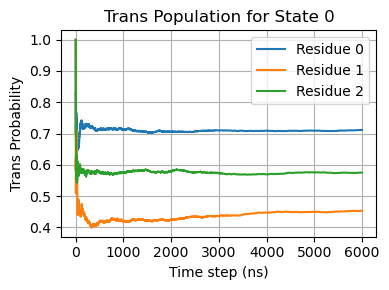

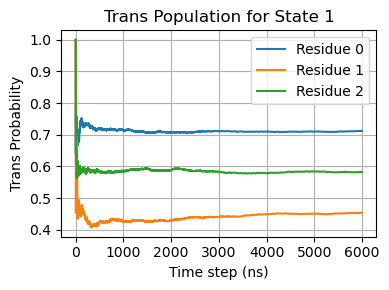

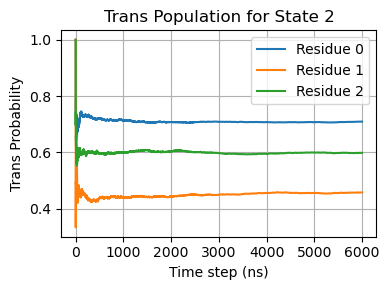

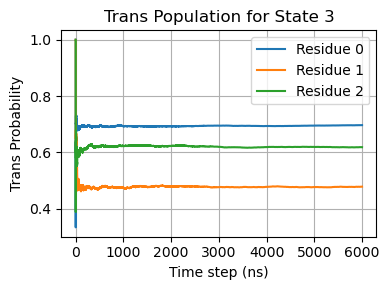

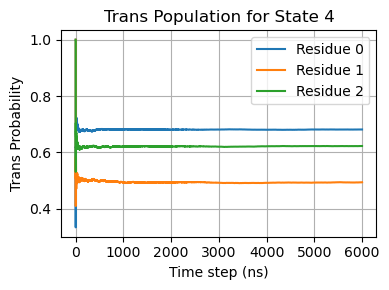

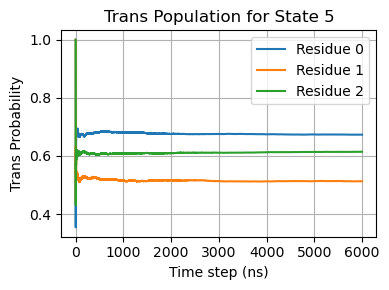

In [17]:
dt_in_ns = 0.01 # 10 ps 

for state_index in range(6):  # Loop over 6 states
    plt.figure(figsize=(4, 3))
    
    for residue_index in range(3):  # Loop over 3 residues
        y = trans_all_population[state_index, residue_index, :]
        x = np.arange(len(y)) * dt_in_ns # or use actual time values

        plt.plot(x, y, label=f'Residue {residue_index}')

    plt.title(f'Trans Population for State {state_index}')
    plt.xlabel('Time step (ns)')
    plt.ylabel('Trans Probability')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


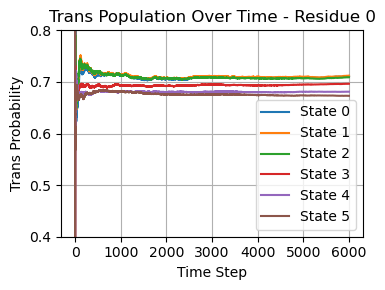

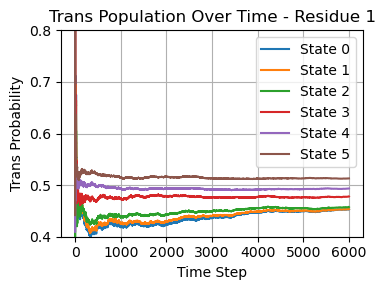

/var/folders/2g/yfyfpy7d3n3fwl_23ytkftvm0000gn/T/ipykernel_77889/1243652195.py:16: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/Users/starwingchen/anaconda3/envs/PeptoidFF/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


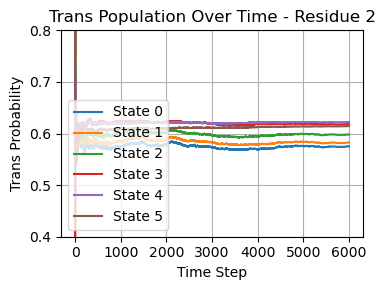

In [18]:
for residue_index in range(3):  # 3 residues
    plt.figure(figsize=(4, 3))

    for state_index in range(6):  # 6 states
        y = trans_all_population[state_index, residue_index, :]
        x = np.arange(len(y)) * dt_in_ns # or use actual time values

        plt.plot(x, y, label=f'State {state_index}')

    plt.title(f'Trans Population Over Time - Residue {residue_index}')
    plt.xlabel('Time Step')
    plt.ylabel('Trans Probability')
    plt.grid(True)
    plt.ylim(0.4, 0.8)
    plt.legend()
    plt.tight_layout()
    plt.show()


## Error Over Times

In [24]:
df_stationary_p = pd.read_csv("autocoorel_data/trans_population_at_lagtime.csv")
#print(df_stationary_p)

    
# Pivot the DataFrame to reshape it
pivot_mean = df_stationary_p.pivot(index='state', columns='res', values='mean')
pivot_std = df_stationary_p.pivot(index='state', columns='res', values='std')

# Convert to NumPy arrays
trans_refer_array = pivot_mean.to_numpy()  # shape (6, 3) state, residues 
trans_refer_err_array = pivot_std.to_numpy()  # shape (6, 3)
trans_refer_array

array([[0.71117256, 0.4531241 , 0.57496825],
       [0.71156356, 0.45335489, 0.58221872],
       [0.70856901, 0.45746632, 0.59787013],
       [0.69658598, 0.47797018, 0.6181369 ],
       [0.68111629, 0.49324147, 0.62237523],
       [0.67308103, 0.5129064 , 0.61450849]])

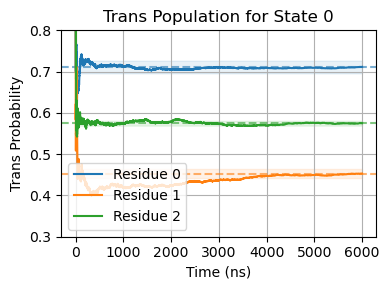

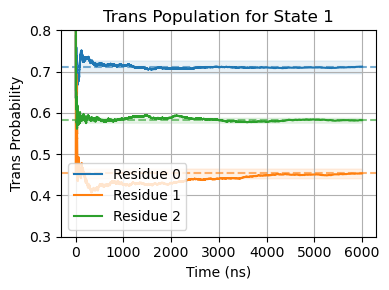

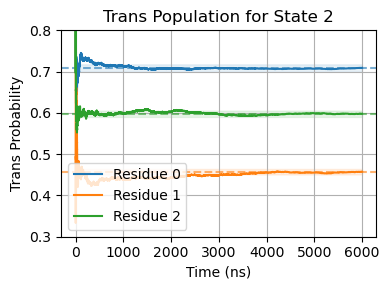

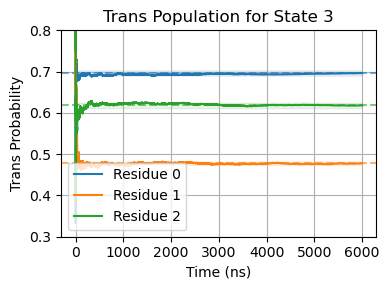

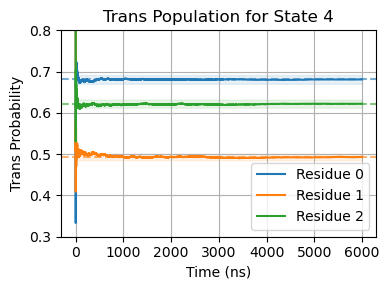

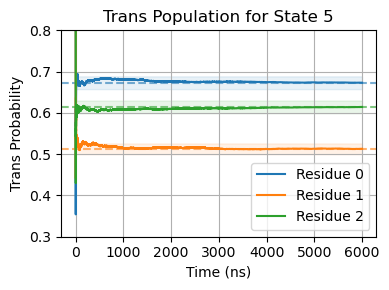

In [26]:
dt_in_ns = 0.01
time_step_to_show = 600000 

for state_index in range(6):  # Loop over 6 states
    plt.figure(figsize=(4, 3))
    for residue_index in range(3):  # Loop over 3 residues
        y = trans_all_population[state_index, residue_index, :]
        x = np.arange(len(y))  # Time steps

        # Plot the time-dependent population with error
        plt.plot(x[:time_step_to_show] * dt_in_ns,
                 y[:time_step_to_show],
                 label=f'Residue {residue_index}')

        # Plot the reference horizontal line with error band
        ref_y = trans_refer_array[state_index, residue_index]
        ref_yerr = trans_refer_err_array[state_index, residue_index]

        plt.axhline(y=ref_y, linestyle='--', color=f'C{residue_index}', alpha=0.6)
        plt.fill_between(x[:time_step_to_show] * dt_in_ns,
                         ref_y - ref_yerr,
                         ref_y + ref_yerr,
                         color=f'C{residue_index}', alpha=0.1)

    plt.title(f'Trans Population for State {state_index}')
    plt.xlabel('Time (ns)')
    plt.ylabel('Trans Probability')
    plt.ylim(0.3, 0.8)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


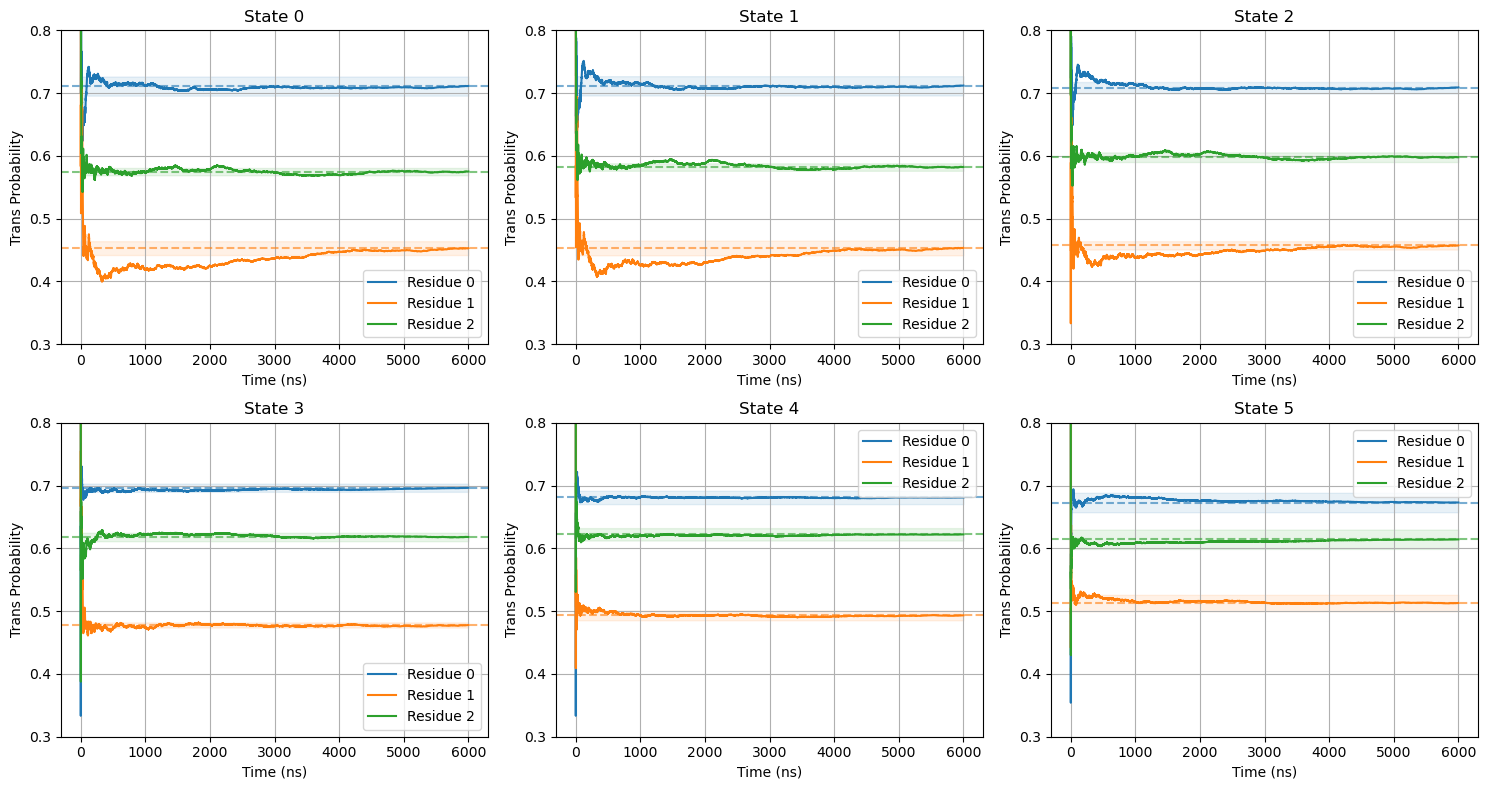

In [28]:
import matplotlib.pyplot as plt
import numpy as np

dt_in_ns = 0.01
time_step_to_show = 600000

fig, axs = plt.subplots(2, 3, figsize=(15, 8))  # 2 rows, 3 columns
axs = axs.flatten()  # Make it easy to index as a flat list

for state_index in range(6):  # Loop over 6 states
    ax = axs[state_index]
    for residue_index in range(3):  # Loop over 3 residues
        y = trans_all_population[state_index, residue_index, :]
        x = np.arange(len(y))

        # Line plot
        ax.plot(x[:time_step_to_show] * dt_in_ns,
                y[:time_step_to_show],
                label=f'Residue {residue_index}')

        # Reference horizontal line and error band
        ref_y = trans_refer_array[state_index, residue_index]
        ref_yerr = trans_refer_err_array[state_index, residue_index]

        ax.axhline(y=ref_y, linestyle='--', color=f'C{residue_index}', alpha=0.6)
        ax.fill_between(x[:time_step_to_show] * dt_in_ns,
                        ref_y - ref_yerr,
                        ref_y + ref_yerr,
                        color=f'C{residue_index}', alpha=0.1)

    ax.set_title(f'State {state_index}')
    ax.set_xlabel('Time (ns)')
    ax.set_ylabel('Trans Probability')
    ax.set_ylim(0.3, 0.8)
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()


### Plot the ERROR

In [31]:
errors_all = []
errors_err_all = []


for res in range(3):
    # Broadcast reference to (6, 600030)
    reference = trans_refer_array[:, res][:, np.newaxis]
    reference_err = trans_refer_err_array[:, res][:, np.newaxis]

    # Compute differences and propagated error
    errors = trans_all_population[:, :, res] - reference
    errors_all.append(errors)

    #plt.plot(errors)
    #plt.show()

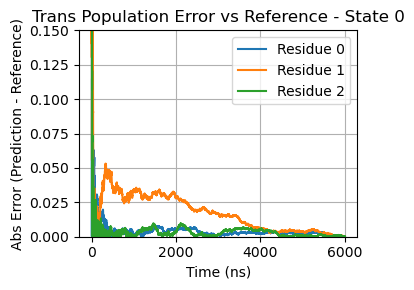

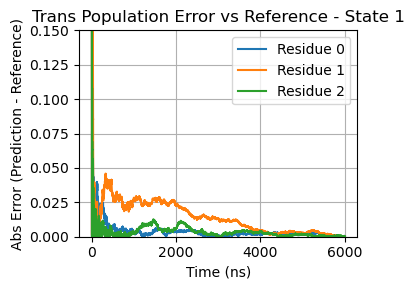

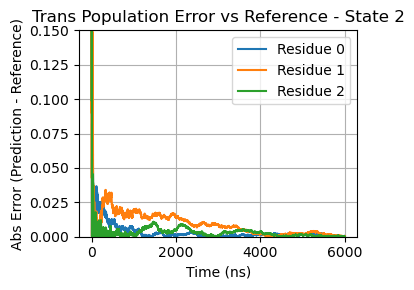

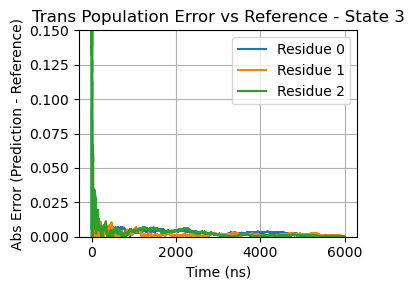

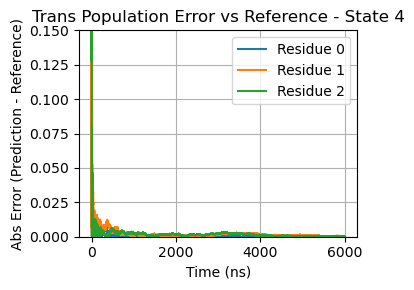

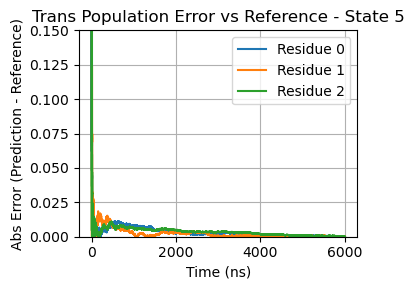

In [39]:
dt_in_ns = 0.01
time_step_to_show = 600000  # 200 ns

errors_all = []

for state_index in range(6):  # Loop over 6 states
    plt.figure(figsize=(4, 3))

    x = np.arange(trans_all_population.shape[2])  # Time axis, e.g., 600030

    errors = []
    for residue_index in range(3):  # Loop over 3 residues
        # Compute absolute error between trajectory and reference
        y = trans_all_population[state_index, residue_index, :]
        ref = trans_refer_array[state_index, residue_index]
        error = np.abs(y - ref)

        errors.append(error)

        # Plot
        plt.plot(x[:time_step_to_show] * dt_in_ns,
                 error[:time_step_to_show],
                 label=f'Residue {residue_index}')

    errors_all.append(errors)

    plt.title(f'Trans Population Error vs Reference - State {state_index}')
    plt.xlabel('Time (ns)')
    plt.ylabel('Abs Error (Prediction - Reference)')
    plt.grid(True)
    plt.legend()
    plt.ylim(0, 0.15)
    plt.tight_layout()
    plt.show()


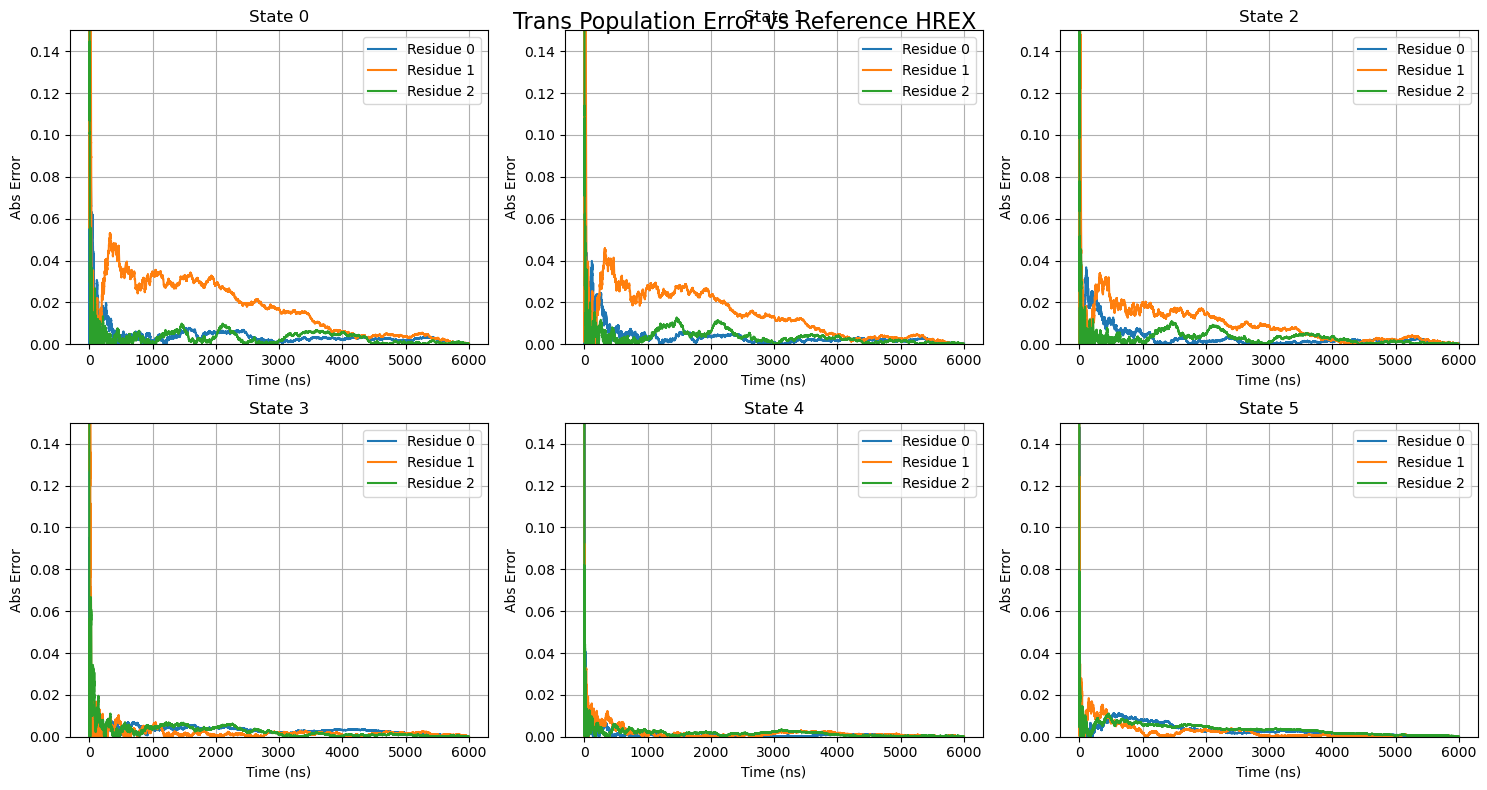

In [45]:
dt_in_ns = 0.01
time_step_to_show = 600000  # 600000 * 0.01 = 6000 ns

errors_all = []

# Create a 2x3 subplot grid
fig, axs = plt.subplots(2, 3, figsize=(15, 8))  # Adjust size as needed
axs = axs.flatten()  # Flatten to 1D for easy indexing

x = np.arange(trans_all_population.shape[2])  # Time axis

for state_index in range(6):
    ax = axs[state_index]

    errors = []
    for residue_index in range(3):
        y = trans_all_population[state_index, residue_index, :]
        ref = trans_refer_array[state_index, residue_index]
        error = np.abs(y - ref)

        errors.append(error)

        # Plot error
        ax.plot(x[:time_step_to_show] * dt_in_ns,
                error[:time_step_to_show],
                label=f'Residue {residue_index}')

    errors_all.append(errors)

    ax.set_title(f'State {state_index}')
    ax.set_xlabel('Time (ns)')
    ax.set_ylabel('Abs Error')
    ax.grid(True)
    ax.set_ylim(0, 0.15)
    ax.legend()

plt.tight_layout()
fig.suptitle("Trans Population Error vs Reference HREX", fontsize=16)
plt.show()

In [42]:
errors_all = np.array(errors_all)
errors_err_all = np.array(errors_err_all)
print(errors_all.shape)
print(errors_err_all.shape)
errors_result = [errors_all, errors_err_all]

os.makedirs('population_data', exist_ok=True)

data_instance = Data(errors_result)
data_instance.save("population_data/error_res.pkl")

(6, 3, 600030)
(0,)
